# Demonstration on 6x6 images

In [34]:
import numpy as np

print(np.random.choice(2, size=(4,)))

[1 0 0 0]


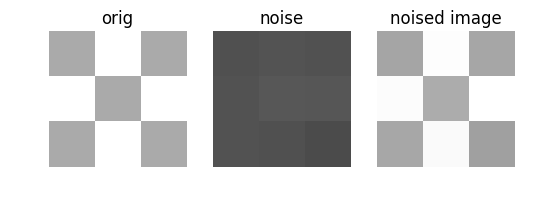

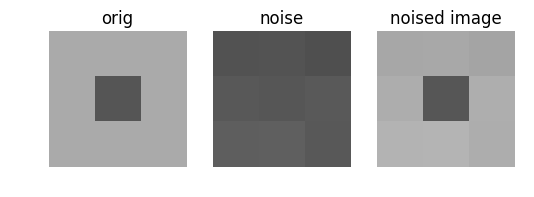

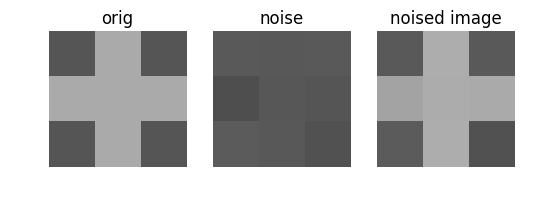

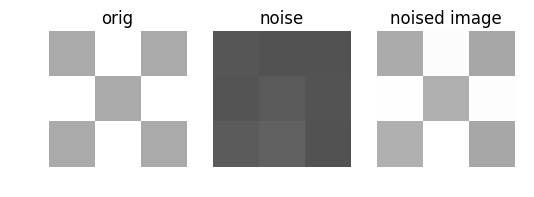

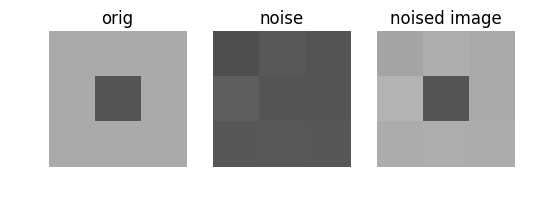

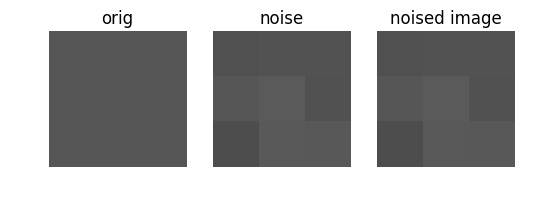

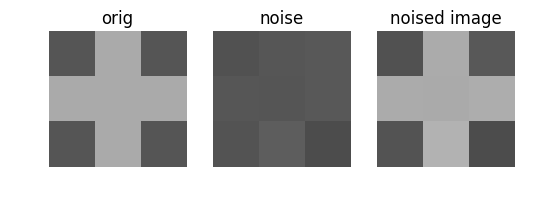

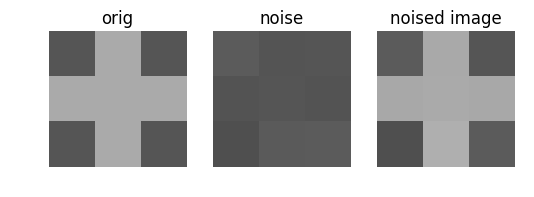

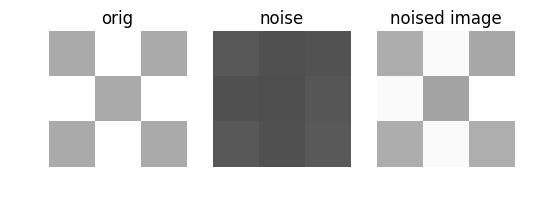

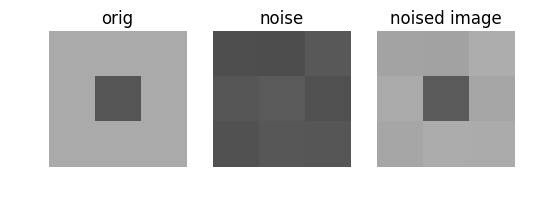

In [108]:
### import numpy as np
import matplotlib.pyplot as plt
import math


num_classes = 2
image_size = 3
N = 10
sigma_X = 0.05

class_descriptions = [
    {
        'sprite': [
            [0,1,0],
            [1,1,1],
            [0,1,0]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,1,1],
            [1,0,1],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 0
    },
    {
        'sprite': [
            [1,0,0],
            [1,1,0],
            [1,1,1]
        ],
        'sprite_x': 0,
        'sprite_y': 3
    },
    {
        'sprite': [
            [1,1,1],
            [0,1,0],
            [0,1,0]
        ],
        'sprite_x': 3,
        'sprite_y': 3
    }
]

def class_descriptions_to_class_pics():
    class_pics = []
    for i, desc in enumerate(class_descriptions):
        if i >= num_classes:
            break
        pic = np.zeros((image_size, image_size), dtype=np.float32)
        for dx in range(3):
            for dy in range(3):
                if desc['sprite'][dy][dx] == 1:
                    pic[desc['sprite_y'] + dy, desc['sprite_x'] + dx] = 1.0
        class_pics.append(pic)
    return class_pics

class_pics = class_descriptions_to_class_pics()
# print(class_pics)

def print_images(titles, images):
    plt.figure(1)
    num_figures = len(images)
    for i, image in enumerate(images):
        image_size = image.shape[0]
        image_min = np.min(image)
        image_max = np.max(image)
        image_min = -1
        image_max = 2
        image_range = image_max - image_min
        image = np.maximum(image_min, image)
        image = np.minimum(image_max, image)
        image = (image - image_min) / image_range
        image_rgb = np.zeros((image_size, image_size, 3), dtype=np.float32)
        image_rgb[:,:,0] = image
        image_rgb[:,:,1] = image
        image_rgb[:,:,2] = image
        plt.subplot(1, num_figures, i + 1)
        plt.imshow(image_rgb, interpolation='nearest')
        plt.axis('off')
        plt.title(titles[i])
    plt.show()

def draw_samples(N, class_pics):
    samples = []
    for n in range(N):
        image = np.zeros((image_size, image_size), dtype=np.float32)
        features = np.random.choice(2, size=(num_classes,))
#         print(features)
        for k, v in enumerate(features):
            if v == 1:
                image += class_pics[k]
        image_orig = np.copy(image)
#         print_image(image)

        noise = np.random.randn(image_size, image_size).astype(np.float32) * sigma_X
#         print_image(noise)

        image += noise
        print_images(['orig', 'noise', 'noised image'], [image_orig, noise, image])

        samples.append(image)
    return samples

samples = draw_samples(N, class_pics)
